### Описание проекта
Cтажировка в отделе аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.

У вас в распоряжении есть данные:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов

#### Изучим общую информацию и обработаем данные

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
from matplotlib.ticker import FuncFormatter

In [2]:
visit = pd.read_csv('/datasets/visits_log.csv')
orders = pd.read_csv('/datasets/orders_log.csv')
costs = pd.read_csv('/datasets/costs.csv')

#### Таблица visit: 

In [3]:
visit.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


Изменим формат столбцов, где есть даты с object на формат даты:

In [4]:
visit['End Ts'] = pd.to_datetime(visit['End Ts'])
visit['Start Ts'] = pd.to_datetime(visit['Start Ts'])

Проверка на наличие пропусков и дубликатов:

In [5]:
print(visit.isnull().sum())

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64


In [6]:
visit.duplicated().sum() 

0

Проверка значений:

In [7]:
visit['Device'].value_counts()

desktop    262567
touch       96833
Name: Device, dtype: int64

In [8]:
visit['Source Id'].value_counts()

4     101794
3      85610
5      66905
2      47626
1      34121
9      13277
10     10025
7         36
6          6
Name: Source Id, dtype: int64

Посмотрим имеются ли в таблице строки, для которых когда время окончания сессии стоит раньше времени начала сессии:

In [9]:
visit['duration'] = visit['End Ts'] - visit['Start Ts']

In [10]:
visit['duration'] = visit['duration'].astype('timedelta64[s]')

In [11]:
visit.query('duration < 0')

,Device,End Ts,Source Id,Start Ts,Uid,duration
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986,-1920.0
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453,-2760.0


Период исследования:

In [12]:
print(visit['Start Ts'].max())
print(visit['Start Ts'].min())

2018-05-31 23:59:00
2017-06-01 00:01:00


In [13]:
print(visit['End Ts'].max())
print(visit['End Ts'].min())

2018-06-01 01:26:00
2017-06-01 00:02:00


Исследуемый период равен году с 2017-06-01 по 2018-06-01

#### Таблица orders:

In [14]:
print(orders)

                    Buy Ts  Revenue                   Uid
0      2017-06-01 00:10:00    17.00  10329302124590727494
1      2017-06-01 00:25:00     0.55  11627257723692907447
2      2017-06-01 00:27:00     0.37  17903680561304213844
3      2017-06-01 00:29:00     0.55  16109239769442553005
4      2017-06-01 07:58:00     0.37  14200605875248379450
...                    ...      ...                   ...
50410  2018-05-31 23:50:00     4.64  12296626599487328624
50411  2018-05-31 23:50:00     5.80  11369640365507475976
50412  2018-05-31 23:54:00     0.30   1786462140797698849
50413  2018-05-31 23:56:00     3.67   3993697860786194247
50414  2018-06-01 00:02:00     3.42     83872787173869366

[50415 rows x 3 columns]


Проверка на наличие пропуском и дубликатов:

In [15]:
print(orders.isnull().sum())

Buy Ts     0
Revenue    0
Uid        0
dtype: int64


In [16]:
orders.duplicated().sum() 

0

In [17]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


Изменим формат столбцов, где есть даты с object на формат даты:

In [18]:
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'])

Проверка значений:

In [19]:
print(orders['Revenue'].max())
print(orders['Revenue'].min())

2633.28
0.0


Если судить по выручке, которую приносят пользователи, то как есть люди, которые вообще не платят, но так же есть и киты, которые приносят большую выручку, нежели большинство платящих пользователей

In [20]:
print(orders['Buy Ts'].max())
print(orders['Buy Ts'].min())

2018-06-01 00:02:00
2017-06-01 00:10:00


#### Таблица costs:

In [21]:
print(costs)

      source_id          dt  costs
0             1  2017-06-01  75.20
1             1  2017-06-02  62.25
2             1  2017-06-03  36.53
3             1  2017-06-04  55.00
4             1  2017-06-05  57.08
...         ...         ...    ...
2537         10  2018-05-27   9.92
2538         10  2018-05-28  21.26
2539         10  2018-05-29  11.32
2540         10  2018-05-30  33.15
2541         10  2018-05-31  17.60

[2542 rows x 3 columns]


Проверка пропусков и дубликатов:

In [22]:
print(costs.isnull().sum())

source_id    0
dt           0
costs        0
dtype: int64


In [23]:
costs.duplicated().sum() 

0

In [24]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Изменим формат столбцов, где есть даты с object на формат даты:

In [25]:
costs['dt'] = pd.to_datetime(costs['dt'])

Проверка значений(рассмотрим максимальное и минимальное значение, чтобы понять диапазон зачений в столбце затрат):

In [26]:
costs['costs'].max()

1788.28

In [27]:
costs['costs'].min()

0.54

Проверим для всех ли рекламных источников указаны расходы:

In [28]:
costs['source_id'].value_counts()

5     364
9     363
3     363
1     363
10    363
4     363
2     363
Name: source_id, dtype: int64

In [29]:
check = costs.groupby('source_id').agg({'costs': 'sum'})
check.head(10)

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Если делать какие-то выводы по предоставленным данным, то таблицы без дубликатов и пропусков, единственное, есть 2 строчки, где время конца сессии раньше нежели ее начало, но исходя из того, что их всего 2 из 350 тысяч строк, оказать какого-то серьезного влияния на полученные результаты они не смогут, расходы на маркетинг и выручка с пользователей, тоже выглядят адекватно, рассматриваемый период ислледоввания год с 2017-06-01 по 2018-06-01. Затраты на маркетинг указаны не для всех источников, отсутствуют 6,7,8 источники.

### Построим отчёты и посчитаем метрики:

#### Сколько людей пользуются в день, неделю, месяц?

In [30]:
visit.head(10)

,Device,End Ts,Source Id,Start Ts,Uid,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,60.0
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,3360.0
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312,60.0
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644,180.0
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063,60.0


Добавим информацию по дню недели сессии, по номеру недели и по месяцу, году

In [31]:
visit['session_date'] = visit['Start Ts'].dt.date
visit['session_week'] = visit['Start Ts'].dt.week
visit['session_month'] = visit['Start Ts'].dt.month
visit['session_year'] = visit['Start Ts'].dt.year
visit['session_day'] = visit['Start Ts'].dt.day

#### Расчитаем метрики DAU, MAU, WAU

In [32]:
visit.head()

,Device,End Ts,Source Id,Start Ts,Uid,duration,session_date,session_week,session_month,session_year,session_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080.0,2017-12-20,51,12,2017,20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680.0,2018-02-19,8,2,2018,19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017-07-01,26,7,2017,1
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440.0,2018-05-20,20,5,2018,20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017-12-27,52,12,2017,27


In [33]:
dau_total = visit.groupby('session_date').agg({'Uid': 'nunique'}).mean()
mau_total = visit.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
wau_total = visit.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()

In [34]:
print(int(dau_total))
print(int(wau_total))
print(int(mau_total))

907
5716
23228


#### Посмотрим на показатели в разрезе платформ:

In [35]:
desktop = visit.query('Device == "desktop"')

In [36]:
dau_total = desktop.groupby('session_date').agg({'Uid': 'nunique'}).mean()
mau_total = desktop.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
wau_total = desktop.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()

In [37]:
print(int(dau_total))
print(int(wau_total))
print(int(mau_total))

659
4129
16724


In [38]:
touch = visit.query('Device == "touch"')

In [39]:
dau_total = touch.groupby('session_date').agg({'Uid': 'nunique'}).mean()
mau_total = touch.groupby(['session_year', 'session_month']).agg({'Uid': 'nunique'}).mean()
wau_total = touch.groupby(['session_year', 'session_week']).agg({'Uid': 'nunique'}).mean()

In [40]:
print(int(dau_total))
print(int(wau_total))
print(int(mau_total))

252
1634
6825


Можно сделать вывод, что количество людей пользующиеся ресурсом, использующие ПК  более, чем в 3 раза больше, чем людей, заходящих через категорию моюильных устройств

#### Посмотрим на показатели в разрезе источников:

In [41]:
dau_total_source = visit.groupby(['Source Id', 'session_date']).agg({'Uid': 'nunique'})


In [42]:
dau_total_source = dau_total_source.groupby('Source Id').agg({'Uid': 'mean'})
dau_total_source.sort_values(by = 'Uid', ascending = False).round()

,Uid
Source Id,
4,275.0
3,233.0
5,176.0
2,121.0
1,81.0
9,36.0
10,26.0
7,1.0
6,1.0


In [43]:
mau_total_source = visit.groupby(['Source Id','session_year', 'session_month']).agg({'Uid': 'nunique'})

In [44]:
mau_total_source = mau_total_source.groupby(['Source Id','session_year']).agg({'Uid': 'mean'})
mau_total_source.sort_values(by = 'Uid', ascending = False).round()

Uid
Source Id session_year        
4         2018          8881.0
3         2018          7131.0
4         2017          6969.0
3         2017          6493.0
5         2018          5051.0
          2017          4994.0
2         2018          3014.0
          2017          2565.0
1         2018          1984.0
          2017          1700.0
9         2018          1074.0
          2017           925.0
10        2018           912.0
          2017           561.0
7         2017             3.0
          2018             2.0
6         2017             1.0
          2018             1.0

In [45]:
wau_total_source = visit.groupby(['Source Id','session_year', 'session_week']).agg({'Uid': 'nunique'})


In [46]:
wau_total_source = wau_total_source.groupby(['Source Id','session_year']).agg({'Uid': 'mean'})
wau_total_source.sort_values(by = 'Uid', ascending = False).round()

Uid
Source Id session_year        
4         2018          2096.0
3         2018          1660.0
4         2017          1640.0
3         2017          1499.0
5         2018          1181.0
          2017          1158.0
2         2018           784.0
          2017           667.0
1         2018           506.0
          2017           433.0
9         2018           260.0
          2017           223.0
10        2018           217.0
          2017           131.0
7         2017             1.0
          2018             1.0
6         2017             1.0
          2018             1.0

Если смотреть на количество людей заходящих на ресурс в разрезе источников, то можно заметить, превосходство источников 4,3,5,2 и практически нулевые показатели 7 и 6 источника

#### Посещаемость взависимости от платформы:

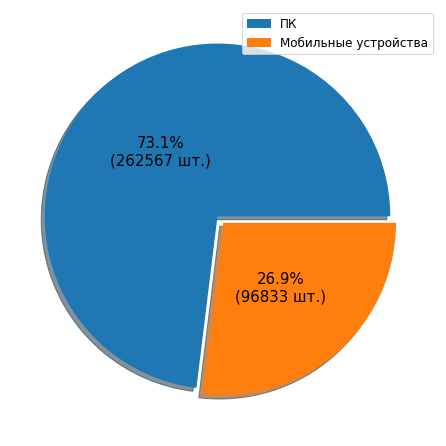

In [47]:
visits_by_device = visit.groupby('Device').agg({'Uid': 'count'})
summary = visits_by_device.values.sum()

def func_pct(pct):
    value = float(pct/100.*summary)
    return "{:.1f}%\n({:.0f} шт.)".format(pct, value)

explode = (0.05, 0)

ax_pie = visits_by_device.plot(kind='pie', y='Uid', fontsize=15, use_index=False, shadow=True, explode=explode,
                         pctdistance=0.5, figsize=(13,6), 
                        autopct=lambda pct: func_pct(pct), labels=None)

plt.tight_layout(pad=0)

legend = ax_pie.legend(['ПК', 'Мобильные устройства'], prop={'size':12})
y_label = ax_pie.set_ylabel('')

Около 75% посещений совершено с ПК, и всего 25 процентов с мобильных устройств, вероятно у данного ресурса нет мобильного преложения, что в свою очередь могло бы улучшить удобство пользования. Нужно тестировать мобильную версию сайта, дабы утонить увеличит ли это количество пользователей мобильных устройств.

#### Посмотрим на показатели в динамике:

In [48]:
total_dinamic = visit.groupby(['session_year','session_month','session_date']).agg({'Uid': 'nunique'})

In [49]:
total_dinamic = total_dinamic.groupby(['session_year','session_month']).agg({'Uid': 'mean'})
total_dinamic.sort_values(by = 'Uid', ascending = False).round()

Uid
session_year session_month        
2017         11             1329.0
             12             1241.0
2018         2              1217.0
2017         10             1133.0
2018         1              1097.0
             3              1053.0
             4               846.0
             5               786.0
2017         9               739.0
             7               532.0
             6               511.0
             8               433.0

Из полученных данных мы видим, что найбольшие показатели по заходу пользователей на ресурс приходятся ближе на конец 2017 года и начало 2018( октябрь, ноябрь , декабрь 2017 и январь, февраль, март 2018). Если предположить, что на момент начала исследования бизнес только открывался, то мы видим положительную динамику с течением времени, но после марта 2018 и вплоть до конца исследования, начинается отрицательная динамика посещений, что говорит о том, что нужно искать причину происходящего

#### Сколько сессий в день?

In [50]:
sessions_per_user = visit.groupby(['session_date']).agg({'Uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']

In [51]:
print(sessions_per_user)

              n_sessions  n_users  sessions_per_user
session_date                                        
2017-06-01           664      605           1.097521
2017-06-02           658      608           1.082237
2017-06-03           477      445           1.071910
2017-06-04           510      476           1.071429
2017-06-05           893      820           1.089024
...                  ...      ...                ...
2018-05-27           672      620           1.083871
2018-05-28          1156     1039           1.112608
2018-05-29          1035      948           1.091772
2018-05-30          1410     1289           1.093871
2018-05-31          2256     1997           1.129695

[364 rows x 3 columns]


Среднее количество посещений ресурсав день:

In [52]:
sessions_per_user['sessions_per_user'].mean()

1.082169644003972

#### Сколько длится одна сессия?

In [53]:
visit['session_duration_sec'] = (visit['End Ts'] - visit['Start Ts']).dt.seconds
print(visit['session_duration_sec'].mean())
print(visit['session_duration_sec'].median())

643.506488592098
300.0


Text(0.5, 1.0, 'Длительность сессии в секундах')

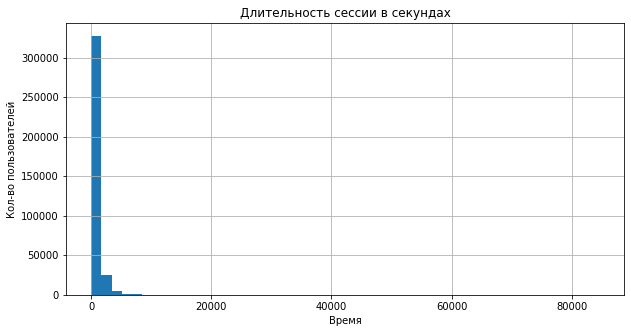

In [54]:
ax = visit['session_duration_sec'].hist(bins=50, figsize=(10,5))
ax.set_ylabel("Кол-во пользователей")
ax.set_xlabel("Время")
ax.set_title('Длительность сессии в секундах')

Когда распределение близко к нормальному или нормальное — можно смотреть на среднюю или медиану. Наше — не из таких, рассчитаем моду (значение в выборке, которое встречается чаще всего):

In [55]:
print(visit['session_duration_sec'].mode())

0    60
dtype: int64


Продолжительность большинства сессий - от 0 до 1 минут. Грубо говоря, пользователи не задерживаются на сайте, заходят делают заказ и уходят

#### Как часто люди возвращаются?

Определим событие и период — на их основе сформируем когорту. Возьмём дату, когда пользователь впервые проявил активность:

In [56]:
first_activity_date = visit.groupby(['Uid'])['session_date'].min()

In [57]:
first_activity_date.name = 'first_activity_date'
visit = visit.join(first_activity_date,on='Uid')

In [58]:
visit['first_activity_month'] = visit['first_activity_date'].astype('datetime64[M]')
visit['activity_month'] = visit['session_date'].astype('datetime64[M]')

Теперь для каждой строки датафрейма можно рассчитать lifetime пользователя в рамках когорты:

In [59]:
visit['cohort_lifetime'] = visit['activity_month'] - visit['first_activity_month']
visit['cohort_lifetime'] = visit['cohort_lifetime'] / np.timedelta64(1,'M')
visit['cohort_lifetime'] = visit['cohort_lifetime'].round().astype(int)

Сгруппируем данные по когорте и lifetime. Посчитаем для каждой когорты количество активных пользователей на определённую «месяц жизни»:

In [60]:
cohorts = visit.groupby(['first_activity_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

In [61]:
print(cohorts)

   first_activity_month  cohort_lifetime    Uid
0            2017-06-01                0  13259
1            2017-06-01                1   1043
2            2017-06-01                2    713
3            2017-06-01                3    814
4            2017-06-01                4    909
..                  ...              ...    ...
73           2018-03-01                1    861
74           2018-03-01                2    557
75           2018-04-01                0  15709
76           2018-04-01                1    760
77           2018-05-01                0  15273

[78 rows x 3 columns]


Найдём исходное количество пользователей в когорте. Возьмём их число на нулевой месяц:

In [62]:
inital_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','Uid']]

In [63]:
inital_users_count = inital_users_count.rename(columns={'Uid':'cohort_users'})

In [64]:
inital_users_count.head()

,first_activity_month,cohort_users
0,2017-06-01,13259
12,2017-07-01,13140
23,2017-08-01,10181
33,2017-09-01,16704
42,2017-10-01,25977


In [65]:
cohorts = cohorts.merge(inital_users_count,on='first_activity_month')

Рассчитаем Retention Rate. Разделим количество активных пользователей в каждую из недель на исходное число пользователей в когорте:

In [66]:
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users']

Построим сводную таблицу и создадим тепловую карту:

In [67]:
retention_pivot = cohorts.pivot_table(index='first_activity_month',columns='cohort_lifetime',values='retention',aggfunc='sum')

In [68]:
retention_pivot.head()

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN


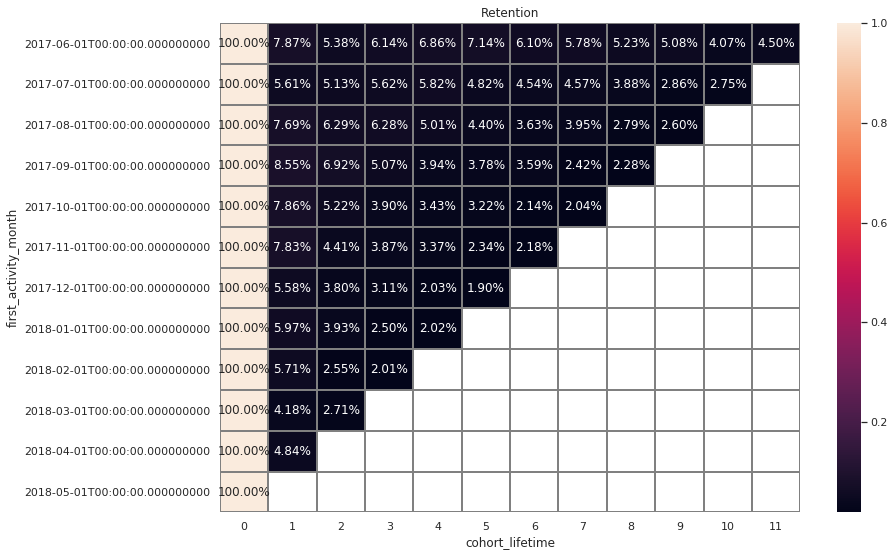

In [69]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.2%', linewidths=1, linecolor='gray');

Замечаем, что Retention достаточно низкий. На фоне всех когорт выделяется первая, которая началапользоватьсяресурсом в июне 2017 года, их Retention,тоже имеет достаточные низкие показатели, но он занимаетлидирующие позиции по сравнению с другими когортами, возможно стоит проанализировать первую когорту и понять почему люди возвращаются охотнее. Так же стоит заметить, что с увеличением времени пользования ресурсом, процент клиентов,  которые возвращаются стабильно падает.

#### Когда люди начинают покупать?

Сгруппируем датафрейм orders по пользователям, чтобы найти дату их первого заказа, и датафрейм visits, чтобы найти дату первой сессии:

In [70]:
orders.head()

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [71]:
first_purchase_date = orders.groupby('Uid')[['Buy Ts']].min().reset_index()
first_purchase_date.columns = ['Uid', 'first_purchase_date']
first_session_date = visit.groupby('Uid')[['Start Ts']].min().reset_index()
first_session_date.columns = ['Uid', 'first_session']

In [72]:
buy = first_purchase_date.merge(first_session_date, on='Uid')

In [73]:
buy.head()

,Uid,first_purchase_date,first_session
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00


Добавим столбец с разницей в минутах между датой и временем первого заказа и датой и временем первой сессии:

In [74]:
buy['diff'] = buy['first_purchase_date'] - buy['first_session']
buy['diff'] = buy['diff']/np.timedelta64(1, 'm')
buy['diff'] = buy['diff'].round(1)
buy.head(10)

,Uid,first_purchase_date,first_session,diff
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.0
2,2429014661409475,2017-10-11 18:33:00,2017-10-11 17:14:00,79.0
3,2464366381792757,2018-01-28 15:54:00,2018-01-27 20:10:00,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.0
5,3077748354309989,2018-03-03 12:33:00,2018-03-03 12:08:00,25.0
6,3605148382144603,2017-09-21 20:56:00,2017-08-15 21:54:00,53222.0
7,3753586865891862,2018-03-03 13:50:00,2018-03-03 13:47:00,3.0
8,4808417689019433,2018-01-09 23:32:00,2018-01-09 23:10:00,22.0
9,4992223027560440,2018-04-04 13:54:00,2018-04-04 13:54:00,0.0


In [75]:
buy['diff'].max()

523144.0

In [76]:
buy['diff'].median()

16.0

Медианное значение времени между моментом совершения заказа и датой и временем первого визита - 16 минут.

Сгруппируем датафрейм по пользователям и по каждому из них выберем минимальную разницу по времени

In [77]:
df = buy.groupby('Uid')[['diff']].min()

Построим гистограмму:

In [78]:
df_h = df.query('diff < 40')

(-1, 50)

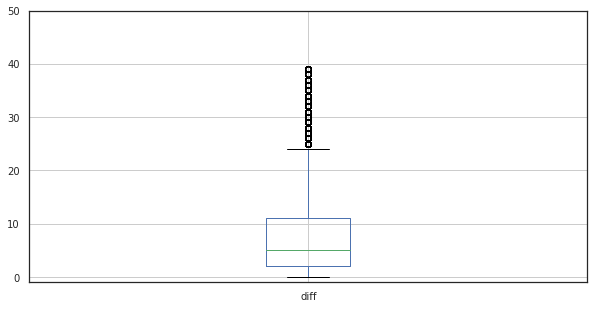

In [79]:
ax = df_h.boxplot(fontsize=10, figsize=(10,5))
ax.set_ylim(-1,50)

Text(0.5, 1.0, 'Время до оформления заказа в минутах')

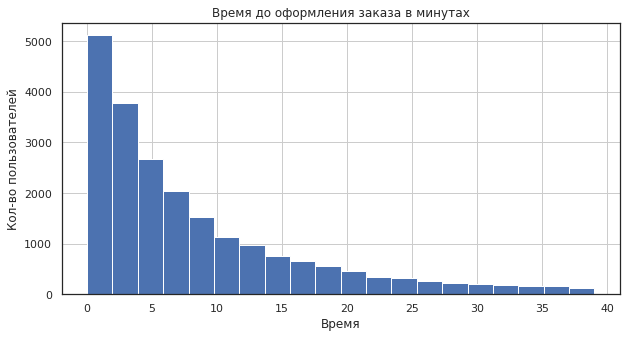

In [80]:
ax = df_h['diff'].hist(bins=20, figsize=(10,5))
ax.set_ylabel("Кол-во пользователей")
ax.set_xlabel("Время")
ax.set_title('Время до оформления заказа в минутах')

Большинство посетителей ресурса на оформление заказа тратят не более 5 минут. То есть они уже знают, что будут покупать, и не тратят время на поиски необходимого им товара

#### Сколько денег приносят? (LTV)

In [81]:
print(orders)

                   Buy Ts  Revenue                   Uid
0     2017-06-01 00:10:00    17.00  10329302124590727494
1     2017-06-01 00:25:00     0.55  11627257723692907447
2     2017-06-01 00:27:00     0.37  17903680561304213844
3     2017-06-01 00:29:00     0.55  16109239769442553005
4     2017-06-01 07:58:00     0.37  14200605875248379450
...                   ...      ...                   ...
50410 2018-05-31 23:50:00     4.64  12296626599487328624
50411 2018-05-31 23:50:00     5.80  11369640365507475976
50412 2018-05-31 23:54:00     0.30   1786462140797698849
50413 2018-05-31 23:56:00     3.67   3993697860786194247
50414 2018-06-01 00:02:00     3.42     83872787173869366

[50415 rows x 3 columns]


Месяц первой покупки:

In [82]:
orders['order_month'] = orders['Buy Ts'].astype('datetime64[M]')

In [83]:
first_orders = orders.groupby('Uid').agg({'order_month': 'min'}).reset_index()
first_orders.columns = ['Uid', 'first_order_month']
print(first_orders.head())

                Uid first_order_month
0   313578113262317        2018-01-01
1  1575281904278712        2017-06-01
2  2429014661409475        2017-10-01
3  2464366381792757        2018-01-01
4  2551852515556206        2017-11-01


Посчитаем количество новых покупателей (n_buyers) за каждый месяц:

In [84]:
cohort_sizes = first_orders.groupby('first_order_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
print(cohort_sizes.head())

  first_order_month  n_buyers
0        2017-06-01      2023
1        2017-07-01      1923
2        2017-08-01      1370
3        2017-09-01      2581
4        2017-10-01      4340


Построим когорты. Добавим месяц первой покупки каждого покупателя в таблицу с заказами:

In [85]:
orders_new = pd.merge(orders,first_orders, on='Uid')
print(orders_new.head())

               Buy Ts  Revenue                   Uid order_month  \
0 2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1 2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2 2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3 2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4 2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   

  first_order_month  
0        2017-06-01  
1        2017-06-01  
2        2017-06-01  
3        2017-06-01  
4        2017-06-01  


Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку

In [86]:
cohorts = orders_new.groupby(['first_order_month','order_month']).agg({'Revenue': 'sum'}).reset_index()
print(cohorts.head())

  first_order_month order_month  Revenue
0        2017-06-01  2017-06-01  9557.49
1        2017-06-01  2017-07-01   981.82
2        2017-06-01  2017-08-01   885.34
3        2017-06-01  2017-09-01  1931.30
4        2017-06-01  2017-10-01  2068.58


С точки зрения когортного анализа LTV — накопительная выручка когорты в пересчёте на количество людей. Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:

In [87]:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')
print(report.head())

  first_order_month  n_buyers order_month  Revenue
0        2017-06-01      2023  2017-06-01  9557.49
1        2017-06-01      2023  2017-07-01   981.82
2        2017-06-01      2023  2017-08-01   885.34
3        2017-06-01      2023  2017-09-01  1931.30
4        2017-06-01      2023  2017-10-01  2068.58


LTV считают не из выручки, а из валовой прибыли. Значит, нужно найти валовую прибыль, умножив выручку на маржинальность. Примем маржинальность за 50 %

In [88]:
margin_rate = 0.5

In [89]:
report['gp'] = report['Revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
print(report.head())

  first_order_month  n_buyers order_month  Revenue        gp  age
0        2017-06-01      2023  2017-06-01  9557.49  4778.745    0
1        2017-06-01      2023  2017-07-01   981.82   490.910    1
2        2017-06-01      2023  2017-08-01   885.34   442.670    2
3        2017-06-01      2023  2017-09-01  1931.30   965.650    3
4        2017-06-01      2023  2017-10-01  2068.58  1034.290    4


Найдём LTV. Разделим валовую прибыль когорт за каждый месяц на общее число пользователей в каждой когорте

In [90]:
report['ltv'] = report['gp'] / report['n_buyers']
    
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
    


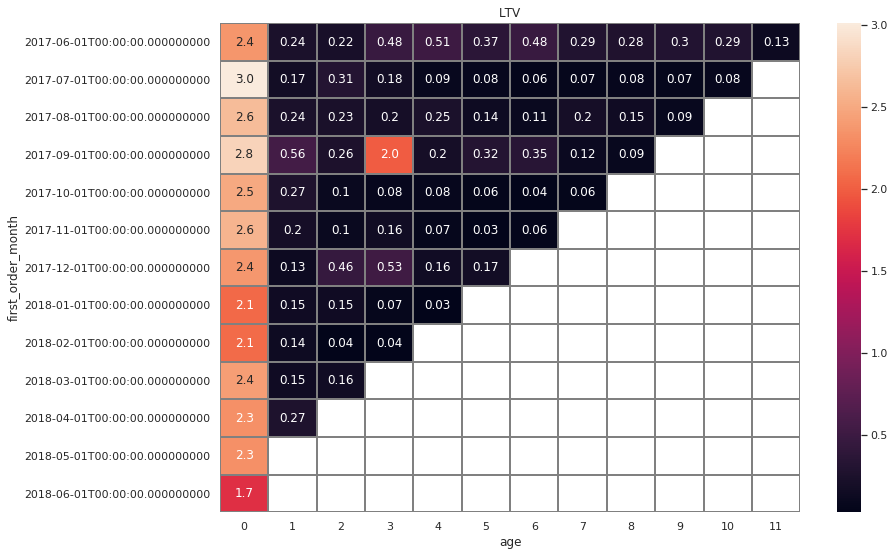

In [91]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV')
sns.heatmap(output, annot=True, fmt='.2', linewidths=1, linecolor='gray');

In [92]:
# отфильруем нужную когорту
cohort_201803 = report[report['first_order_month'] == '2017-06-01']

# посчитаем расходы за этот месяц
costs_201803 = costs[costs['dt'] == '2017-06-01']['costs'].sum()

n_buyers_201803 = cohort_201803['n_buyers'][0]
cac_201803 = costs_201803 / n_buyers_201803
ltv_201803   = output.loc['2017-06-01'].sum()

In [93]:
print('CAC =', cac_201803)
print('LTV =', ltv_201803)

CAC = 0.3634503213049926
LTV = 5.949999999999999


Исходя из полученных данных можно увидеть , что первая когорта  практически в каждом месяце  показывает лучший результат по LTV среди всех когорт. Связано это с тем, что именно эта когорта имеет лучший показатель Retention. Так же стоит рассмотреть 3 месяц 4 когорты, там имеет аномально высокое значение, нужно узнать причину 

#### Сколько раз покупают за период?

In [94]:
print(orders)

                   Buy Ts  Revenue                   Uid order_month
0     2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01
1     2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01
2     2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01
3     2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01
4     2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01
...                   ...      ...                   ...         ...
50410 2018-05-31 23:50:00     4.64  12296626599487328624  2018-05-01
50411 2018-05-31 23:50:00     5.80  11369640365507475976  2018-05-01
50412 2018-05-31 23:54:00     0.30   1786462140797698849  2018-05-01
50413 2018-05-31 23:56:00     3.67   3993697860786194247  2018-05-01
50414 2018-06-01 00:02:00     3.42     83872787173869366  2018-06-01

[50415 rows x 4 columns]


Сгруппируем по пользователям и найдем у каждого время первого заказа

In [95]:
first_purchase = orders.groupby('Uid')['Buy Ts'].min().reset_index()
first_purchase.columns = ['Uid', 'date_of_first_purchase']
order_df = pd.merge(orders, first_purchase, on='Uid')
order_df.head(10)

,Buy Ts,Revenue,Uid,order_month,date_of_first_purchase
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01 08:43:00
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01 08:54:00
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-01 08:54:00
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01 09:22:00
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01 09:22:00


In [96]:
order_df['diff'] = order_df['Buy Ts'] - order_df['date_of_first_purchase']
order_df['diff'] = order_df['diff']/np.timedelta64(1, 'M')
order_df['diff'] = order_df['diff'].round().astype('int')
order_df['date_of_first_purchase'] = order_df['date_of_first_purchase'].astype('datetime64[M]')
order_df.head(10)

,Buy Ts,Revenue,Uid,order_month,date_of_first_purchase,diff
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01,0
5,2017-06-01 08:43:00,0.18,10402394430196413321,2017-06-01,2017-06-01,0
6,2017-06-01 08:54:00,1.83,12464626743129688638,2017-06-01,2017-06-01,0
7,2017-06-05 14:30:00,7.33,12464626743129688638,2017-06-01,2017-06-01,0
8,2017-06-01 09:22:00,1.22,3644482766749211722,2017-06-01,2017-06-01,0
9,2017-06-02 12:44:00,0.85,3644482766749211722,2017-06-01,2017-06-01,0


Выделим когорты по первой сессии, по месяцам и посчитаем количество заказов за данный конкретный месяц, количество уникальных пользователей и количество заказов на одного пользователя:

In [97]:
p_cohorts = (order_df
                                                .groupby(['date_of_first_purchase','diff'])
                                                .agg({'Buy Ts': 'count', 'Uid': 'nunique'})
                               )

p_cohorts['purchases_per_user'] = p_cohorts['Buy Ts']/p_cohorts['Uid']
p_cohorts = p_cohorts.reset_index()
p_cohorts.head(15)

,date_of_first_purchase,diff,Buy Ts,Uid,purchases_per_user
0,2017-06-01,0,2355,2023,1.164113
1,2017-06-01,1,147,58,2.534483
2,2017-06-01,2,152,48,3.166667
3,2017-06-01,3,236,57,4.140351
4,2017-06-01,4,278,82,3.390244
5,2017-06-01,5,204,61,3.344262
6,2017-06-01,6,276,63,4.380952
7,2017-06-01,7,197,45,4.377778
8,2017-06-01,8,211,61,3.459016
9,2017-06-01,9,174,42,4.142857


In [98]:
p_pivot = p_cohorts.pivot_table(index='date_of_first_purchase', 
                                                          columns='diff', 
                                                          values='purchases_per_user')

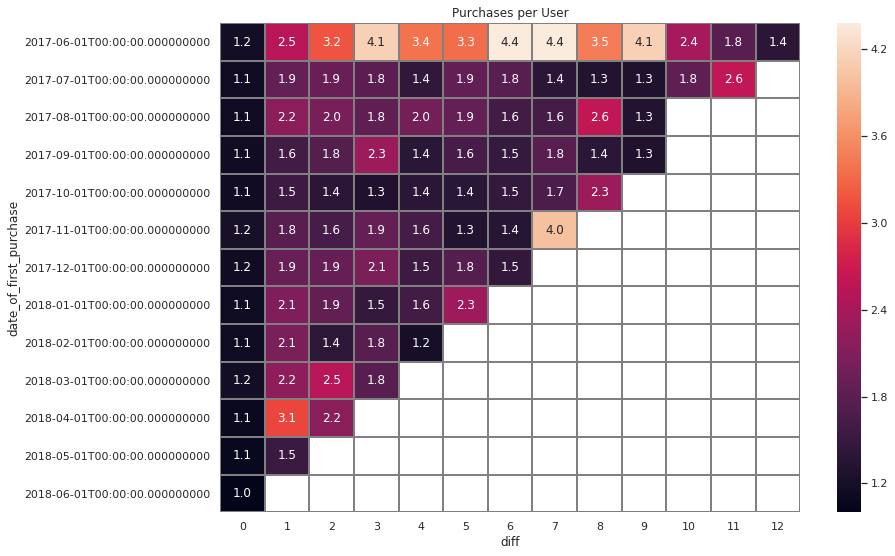

In [99]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Purchases per User')
sns.heatmap(p_pivot, annot=True, fmt='.2', linewidths=1, linecolor='gray');

Первая когорта занимает лидирующие позиции, количество заказоввмесяц превышает 3. Если рассматривать общие показатели,то среднее количество заказов за месяц стримится к 2. 

In [100]:
p_cohorts['purchases_per_user'].mean().round()

2.0

#### Какой средний чек?

In [101]:
print(order_df)

                   Buy Ts  Revenue                   Uid order_month  \
0     2017-06-01 00:10:00    17.00  10329302124590727494  2017-06-01   
1     2017-06-01 00:25:00     0.55  11627257723692907447  2017-06-01   
2     2017-06-01 00:27:00     0.37  17903680561304213844  2017-06-01   
3     2017-06-01 00:29:00     0.55  16109239769442553005  2017-06-01   
4     2017-06-01 07:58:00     0.37  14200605875248379450  2017-06-01   
...                   ...      ...                   ...         ...   
50410 2018-05-31 23:50:00     4.64  12296626599487328624  2018-05-01   
50411 2018-05-31 23:50:00     5.80  11369640365507475976  2018-05-01   
50412 2018-05-31 23:54:00     0.30   1786462140797698849  2018-05-01   
50413 2018-05-31 23:56:00     3.67   3993697860786194247  2018-05-01   
50414 2018-06-01 00:02:00     3.42     83872787173869366  2018-06-01   

      date_of_first_purchase  diff  
0                 2017-06-01     0  
1                 2017-06-01     0  
2                 2017-0

In [102]:
check = (order_df
                                                .groupby(['date_of_first_purchase','diff'])
                                                .agg({'Revenue': 'sum', 'Uid': 'count'})
                               )

check['mean_check'] = check['Revenue']/check['Uid']
check = check.reset_index()
check.head(15)

,date_of_first_purchase,diff,Revenue,Uid,mean_check
0,2017-06-01,0,9620.09,2355,4.084964
1,2017-06-01,1,783.90,147,5.332653
2,2017-06-01,2,771.15,152,5.073355
3,2017-06-01,3,1736.89,236,7.359703
4,2017-06-01,4,2213.74,278,7.963094
5,2017-06-01,5,1447.43,204,7.095245
6,2017-06-01,6,1811.80,276,6.564493
7,2017-06-01,7,1113.33,197,5.651421
8,2017-06-01,8,1460.27,211,6.920711
9,2017-06-01,9,1277.06,174,7.339425


In [103]:
check_pivot = check.pivot_table(index='date_of_first_purchase', 
                                                          columns='diff', 
                                                          values='mean_check')

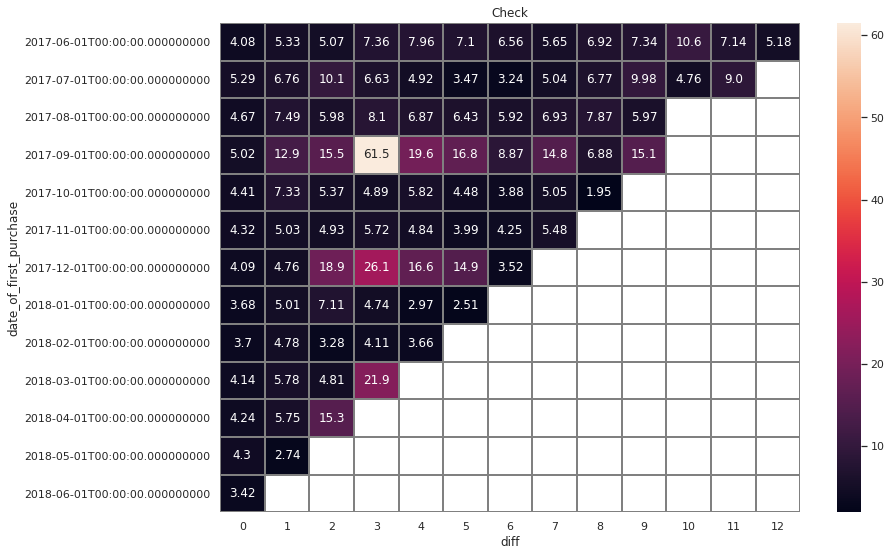

In [104]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Check')
sns.heatmap(check_pivot, annot=True, fmt='.3', linewidths=1, linecolor='gray');

In [105]:
check['mean_check'].mean().round()

8.0

Медиальное значение среднего чека равняется 8. Если взгянуть на тепловую карту можно увидеть, несколько зон с аномальными значениями это сентябрьская и декабрьская кагорты. Необходимо изучить поведение клиентов этих когорт и решить, что могло вызвать такое желание к совершению покупок

#### Сколько денег потратили? Всего / на каждый источник / по времени

In [106]:
print(costs)

      source_id         dt  costs
0             1 2017-06-01  75.20
1             1 2017-06-02  62.25
2             1 2017-06-03  36.53
3             1 2017-06-04  55.00
4             1 2017-06-05  57.08
...         ...        ...    ...
2537         10 2018-05-27   9.92
2538         10 2018-05-28  21.26
2539         10 2018-05-29  11.32
2540         10 2018-05-30  33.15
2541         10 2018-05-31  17.60

[2542 rows x 3 columns]


Количество средств потраченное на каждый источник:

In [107]:
sum_costs = costs.groupby(['source_id']).agg({'costs': 'sum'})

In [108]:
sum_costs.head(10)

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


Суммарное количество потраченных средств:

In [109]:
sum_costs['costs'].sum().round()

329132.0

По месяцам:

In [110]:
costs['month'] = costs['dt'].dt.to_period('M')

In [111]:
month_costs = costs.groupby(['month']).agg({'costs': 'sum'})

In [112]:
month_costs.head()

,costs
month,
2017-06,18015.00
2017-07,18240.59
2017-08,14790.54
2017-09,24368.91
2017-10,36322.88


Text(0.5, 1.0, 'Динамика затрат')

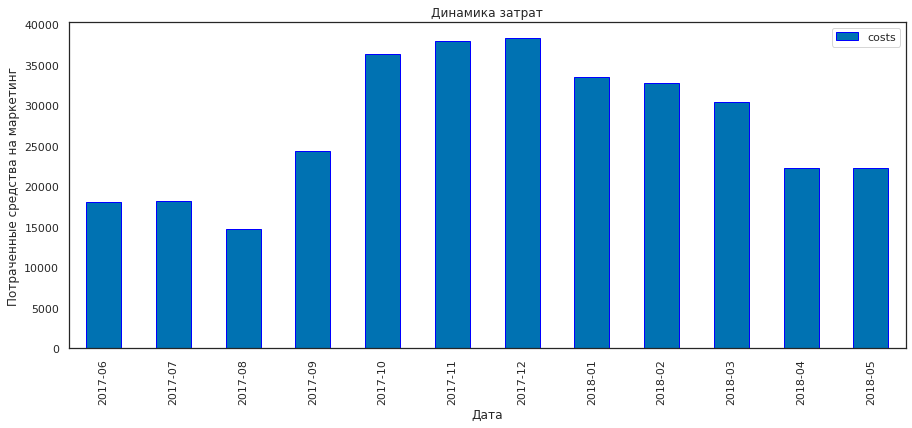

In [113]:
plt.style.use('seaborn-colorblind')
month_costs = costs.groupby(['month']).agg({'costs': 'sum'})
plot = month_costs.plot(kind='bar', y='costs', figsize=(15,6), ec='blue')
plot.set_ylabel("Потраченные средства на маркетинг")
plot.set_xlabel("Дата")
plot.set_title('Динамика затрат')

#### Сколько стоило привлечение одного покупателя из каждого источника?

In [114]:
visit.head()

,Device,End Ts,Source Id,Start Ts,Uid,duration,session_date,session_week,session_month,session_year,session_day,session_duration_sec,first_activity_date,first_activity_month,activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,1080.0,2017-12-20,51,12,2017,20,1080,2017-12-20,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,1680.0,2018-02-19,8,2,2018,19,1680,2018-02-19,2018-02-01,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,0.0,2017-07-01,26,7,2017,1,0,2017-07-01,2017-07-01,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,1440.0,2018-05-20,20,5,2018,20,1440,2018-03-09,2018-03-01,2018-05-01,2
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,0.0,2017-12-27,52,12,2017,27,0,2017-12-27,2017-12-01,2017-12-01,0


In [115]:
orders.head()

,Buy Ts,Revenue,Uid,order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01


In [116]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


Покупатели по каналам:

In [117]:
visits_sorted = visit.sort_values(by='Start Ts')

Затраты по каналам:

In [118]:
costs_per_source = costs.groupby('source_id').agg({'costs': 'sum'})

Выручка по каналам:

In [119]:
first_source_per_user = visits_sorted.groupby('Uid').agg({'Source Id': 'first'})
client_per_source = orders.merge(first_source_per_user, on='Uid')
client_per_source = client_per_source.groupby('Source Id').agg({'Uid': 'nunique'})

Уникальные пользователи по каналам:

In [120]:
uid_per_source = visits_sorted.groupby('Source Id').agg({'Uid': 'nunique'})

rev_per_source = orders.merge(first_source_per_user, on='Uid')
rev_per_source = rev_per_source.groupby('Source Id').agg({'Revenue': 'sum'})

rev_uid_costs_per_source = pd.concat([costs_per_source, rev_per_source, 
                                      uid_per_source, client_per_source],axis=1).fillna(0)
rev_uid_costs_per_source = rev_uid_costs_per_source.reset_index()
rev_uid_costs_per_source['index'] = 'source ' + rev_uid_costs_per_source['index'].astype('str')
rev_uid_costs_per_source = rev_uid_costs_per_source.set_index('index')
rev_uid_costs_per_source.columns = ['costs', 'Revenue', 'Uid', 'clients']

In [121]:
rev_uid_costs_per_source.head(10)

,costs,Revenue,Uid,clients
index,,,,
source 1,20833.27,31090.55,18999,2899.0
source 2,42806.04,46923.61,26245,3506.0
source 3,141321.63,54511.24,74756,10473.0
source 4,61073.60,56696.83,83525,10296.0
source 5,51757.10,52624.02,56974,6931.0
source 6,0.00,0.00,6,0.0
source 7,0.00,1.22,34,1.0
source 9,5517.49,5759.40,9264,1088.0
source 10,5822.49,4450.33,8067,1329.0


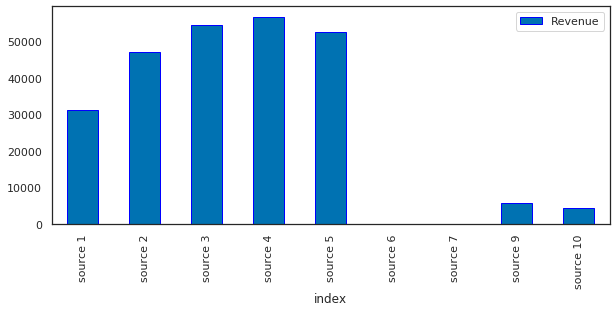

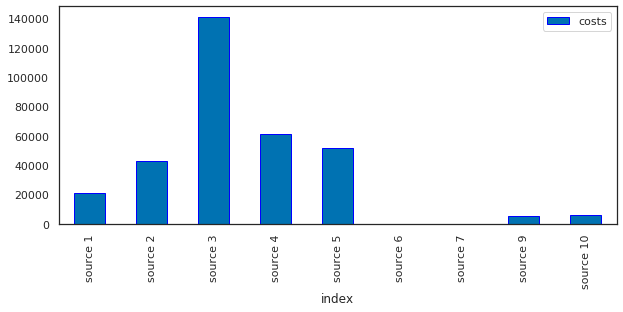

In [122]:
plt.style.use('seaborn-colorblind')
plot = rev_uid_costs_per_source.plot(kind='bar', y='Revenue', figsize=(10,4), ec='blue')
plot1 = rev_uid_costs_per_source.plot(kind='bar', y='costs', figsize=(10,4), ec='blue')


Стоимость привлечения одного клиента по каждому из каналов рекламы:

In [123]:
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['costs']/rev_uid_costs_per_source['clients']
rev_uid_costs_per_source['price_for_client'] = rev_uid_costs_per_source['price_for_client'].round(2)
rev_uid_costs_per_source['price_for_client'].sort_values(ascending=False).to_frame()

,price_for_client
index,
source 3,13.49
source 2,12.21
source 5,7.47
source 1,7.19
source 4,5.93
source 9,5.07
source 10,4.38
source 7,0.00
source 6,NaN


Заметим, что в 3ий рекламный канал мы делаем больше всего вложений. Тем не менее, этот канал не является абсолютным лидером по размеру выручки.  4ый канал с  меньшим рекламным бюджетом дает нам не на много, но большую выручку, чем 3ий канал. С чуть меньшими рекламными затратами, но с примерно схожими показателями по выручке идут 2ой и 5ый каналы.Так же есть 6,7,9,10 каналы,но они совсем слабые,видимо было принято решение, что данные каналы рекламы не эффективны и не стоит особо в них вкладываться.

### На сколько окупились расходы? (ROI)

In [124]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06
1,1,2017-06-02,62.25,2017-06
2,1,2017-06-03,36.53,2017-06
3,1,2017-06-04,55.00,2017-06
4,1,2017-06-05,57.08,2017-06


In [125]:
costs['month'] = costs['dt'].astype('datetime64[M]')

Посчитаем CAC каждой когорты. Сначала найдём суммарные расходы за каждый месяц, а затем поделим их на количество покупателей в каждой когорте:

In [126]:
monthly_costs = costs.groupby('month').sum()
monthly_costs.head()

,source_id,costs
month,,
2017-06-01,1020,18015.00
2017-07-01,1054,18240.59
2017-08-01,1054,14790.54
2017-09-01,1020,24368.91
2017-10-01,1054,36322.88


Добавим данные о расходах в отчёт и посчитаем CAC:

In [127]:
report_new = pd.merge(report, monthly_costs, left_on='first_order_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new.head()

,first_order_month,n_buyers,order_month,Revenue,gp,age,ltv,source_id,costs,cac
0,2017-06-01,2023,2017-06-01,9557.49,4778.745,0,2.362207,1020,18015.0,8.905091
1,2017-06-01,2023,2017-07-01,981.82,490.910,1,0.242664,1020,18015.0,8.905091
2,2017-06-01,2023,2017-08-01,885.34,442.670,2,0.218819,1020,18015.0,8.905091
3,2017-06-01,2023,2017-09-01,1931.30,965.650,3,0.477336,1020,18015.0,8.905091
4,2017-06-01,2023,2017-10-01,2068.58,1034.290,4,0.511265,1020,18015.0,8.905091


Рассчитаем ROMI: поделим LTV на CAC

In [128]:
report_new['romi'] = report_new['ltv'] / report_new['cac']
output = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

output.cumsum(axis=1).round(2)

age,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,0.27,0.29,0.32,0.37,0.43,0.47,0.52,0.56,0.59,0.62,0.65,0.67
2017-07-01,0.32,0.33,0.37,0.39,0.40,0.40,0.41,0.42,0.43,0.43,0.44,NaN
2017-08-01,0.24,0.27,0.29,0.31,0.33,0.34,0.35,0.37,0.38,0.39,NaN,NaN
2017-09-01,0.30,0.36,0.39,0.60,0.62,0.65,0.69,0.70,0.71,NaN,NaN,NaN
2017-10-01,0.30,0.33,0.34,0.35,0.36,0.37,0.37,0.38,NaN,NaN,NaN,NaN
2017-11-01,0.28,0.30,0.31,0.33,0.34,0.34,0.34,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.27,0.29,0.34,0.40,0.42,0.44,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.21,0.22,0.24,0.25,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.23,0.25,0.25,0.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


При при margin_rate = 0.5 все каналы рекламы оказались убыточными

### Вывод:

Что мы получаем по итогу, что нужно что-то менять, по полученным данным мы видим очень низкие показатели retention, что говорит о том, что люди не хотят возвращаться обратно, так же время сессий, которое в большинстве случаев не превышает минуты, то есть люди заходят и практически сразу выходят. Так же количество покупок в месяцих количество равно 2. Выделяется конечно, одна когорта, которая по большинству ключевых показателей лидирует, но и ее данные выглядет не радостно. Возможно стоит исследовать данную кагорту и понять, что же такое  произошло, что повысило показатели. Если рассматривать маркетинг, то на мой взгляд нужно перераспределить расходы по каналам рекламы, в нашем случае было вложено около половины бюджета в 3 канал, а по итогу мы получили, что другие каналы при гораздо меньших затратах получили схожую или дальше даже большую выручку. Если же смотреть на ROI при маржинальности в 50% не добрался ни в одной когорте до 1, что говорится о убыточности бизнеса. 